# Assignment 1-B

We have to fit various regression models to a dataset containing 547 samples, where the $i$-th sample is of the form:

$$ (x_1^{(i)}, x_2^{(i)}, y^{(i)}) $$

where $(x_1^{(i)}, x_2^{(i)})$ are the features and $y^{(i)}$ is the target value. 

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import ceil
from mpl_toolkits import mplot3d

In [3]:
# data = pd.read_csv("fods_1.csv").to_numpy()
data = pd.read_csv("fods_1.csv")

We create a 80-20 split of the dataset for training and testing respectively.

In [4]:
training_data = data.sample(frac = 0.8)
test_data = data.drop(training_data.index)

training_data = training_data.to_numpy()
test_data = test_data.to_numpy()

X_train = training_data[:, :2].T
Y_train = training_data[:,2].T

X_test = test_data[:,:2].T
Y_test = test_data[:,2].T

N_train = len(X_train[0])
N_test = len(X_test[0])

### Structure of matrices

Our feature matrix is stored as:

$$ X = \begin{pmatrix}
x_1^{(1)} & x_1^{(2)} & \ldots & x_1^{(N)}\\
x_2^{(1)} & x_2^{(2)} & \ldots & x_2^{(N)}
\end{pmatrix}_{2 \times N} $$

and the target vector is stored as:

$$ Y = \begin{pmatrix}
y^{(1)} & y^{(2)} & \ldots & y^{(N)}
\end{pmatrix}_{1 \times N}  $$



# POLYNOMIAL REGRESSION

### Our model

$$ f_{\textbf{w}}(x^{(i)}) = \sum_{j=0}^{d} w_jx_j^{(i)} $$

where $x_0^{(i)} = 1$ for all training examples, $x_1^{(i)}$ and $x_2^{(i)}$ correspond to the features in dataset and the remaining $x_j^{(i)}$'s refer to higher degree terms found by multiplying $x_1^{(i)}$ and $x_2^{(i)}$.

### Normalization

We calculate the mean ($\mu$) and standard deviation ($\sigma$) of the training data. We normalize training data as:

$$ x_j^{(i)} = \frac{x_j^{(i)} - \mu_j}{\sigma_j} $$

We also store $\mu$ and $\sigma$ vectors to normalize the testing data using the same $\mu$ and $\sigma$.

In [5]:
def normalize_train(X):

    mean = np.array(np.mean(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])
    std = np.array(np.std(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])

    mean = np.concatenate((np.zeros([1,1]), mean), axis = 0)
    std = np.concatenate((np.ones([1,1]), std), axis = 0)

    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return (X, mean, std)

In [6]:
def normalize_test(X, mean, std):
    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return X

### Generating Feature Matrix

We generate feature matrix for higher degree polynomial regression using nested for loops.

In [7]:
def generate_feature_matrix(X, deg):

    mat = np.ones([1,len(X[0])])
    for i in range (1, deg + 1):
        for j in range(i+1):
            k = i - j
            newRow = np.array((X[0]**j) * (X[1]**k)).reshape([1, len(X[0])])
            mat = np.concatenate((mat, newRow), axis = 0)
            
    # return normalize(mat)
    return mat

### Loss Function

We calculate loss function for regression as follows:
$$ J(\textbf{w}) = \frac{1}{2N} \sum_{i=1}^N (y^{(i)} - f_{\textbf{w}}(x^{(i)}))^2 $$

In [8]:
def loss_function(Y, X, W):
    return np.sum(1 / (2 * len(X[0])) * np.power((Y - W.T @ X), 2))

### Gradient Descent

We implement gradient descent by updating the weights for a fixed number of iterations:

$$ w_j = w_j - \alpha\frac{\partial J(\textbf{w})}{\partial w_j} $$

where $\alpha$ is the learning rate, and

$$ \frac{\partial J(\textbf{w})}{\partial w_j} = \frac{1}{N} \sum_{i=1}^{N} (y^{(i)} - f_{\textbf{w}}(x^{(i)}))(-x_j^{(i)}) $$

In [9]:
def gradient_descent(Y, X, W, alpha, iterations):
    
    N = len(X[0])
    cost = np.zeros(iterations)

    for i in range(iterations):
        W = W - (alpha / N)*((-X) @ (Y - W.T @ X).T)
        cost[i] = loss_function(Y, X, W)
    
    return W, cost

### Stochastic Gradient Descent

We implement stochastic gradient descent similarly, the loss and its gradient is calculated with respect to a randomly chosed sample (instead of all samples) on every iteration.

Loss function for SGD:

$$ J(\textbf{w}) = \frac{1}{2} (y^{(i)} - f_{\textbf{w}}(x^{(i)}))^2 $$

Gradient of loss function for SGD:

$$ \frac{\partial J(\textbf{w})}{\partial w_j} = (y^{(i)} - f_{\textbf{w}}(x^{(i)}))(-x_j^{(i)}) $$

$i$ is chosen randomly from $(1, N)$ for every iteration.

In [10]:
def stochastic_descent(Y, X, W, alpha, iterations):

    N = len(X[0])
    M = len(X)
    cost = np.zeros(iterations)

    for i in range(iterations):

        index = random.randint(0, N - 1)
        Xi = X[:, index].reshape([M, 1])
        Yi = Y[index].reshape([1, 1])

        W = W - (alpha / N) * ((-Xi) @ (Yi - W.T @ Xi).T)
        cost[i] = loss_function(Y, X, W)

    return W, cost

In [11]:
def training_polynomial_regression(Y, X, descent_type):

    error_history = np.zeros([10, 1])
    W_history = []

    # plt.title("Polynomial regression")
    # plt.xlabel("Iterations")
    # plt.ylabel("Error")

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)

        _X = X[:count, :]
        W = np.zeros([count, 1])

        iterations = 100000
        # alpha_array = []
        # final_cost_array = []

        alpha = 0.04

        # while(alpha >= 0.001):

        #     W_grad, cost_grad = descent_type(Y, _X, W, alpha, iterations)
        #     rounded_cost = float("{:.4f}".format(cost_grad[len(cost_grad) - 1]))
        #     alpha_array.append(alpha)
        #     final_cost_array.append(rounded_cost)

        #     alpha -= 1e-3
        
        # plt.plot(alpha_array, )

        W_desc, cost_desc = descent_type(Y, _X, W, alpha, iterations)

        grad_descent_graph = np.array([i for i in range (len(cost_desc))])

        # title_string = "Polynomial Regression for degree " + str(i)
        rounded_cost = float("{:.4f}".format(cost_desc[len(cost_desc) - 1]))

        error_history[i][0] = rounded_cost 
        # W_history[i] = W_history[i].reshape([1, len(W_desc)])
        W_history.append(W_desc.reshape([len(W_desc)]))

        plt.plot(grad_descent_graph, cost_desc)
        
        # plt.show()

        # plt.plot(alpha_array, final_cost_array)
        # plt.show()
    
    plt.show()

    return error_history, W_history

In [12]:
def testing_polynomial_regression(Y, X, W):

    error_history = np.zeros([10, 1])

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)
        print(f"{X.shape}")
        _X = X[:count, :]
        
        error_history[i][0] = loss_function(Y, _X, W[i])
    
    return error_history

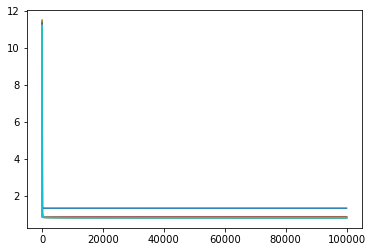

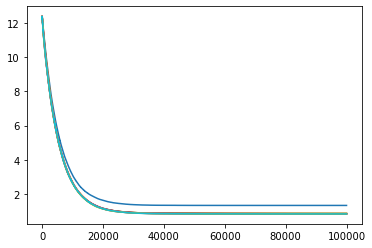

In [13]:
X = generate_feature_matrix(X_train, 9)
(X, mean_norm, std_norm) = normalize_train(X)
training_error_gradient, W_gradient = training_polynomial_regression(Y_train, X, gradient_descent)
training_error_stochastic, W_stochastic = training_polynomial_regression(Y_train, X, stochastic_descent)

(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)


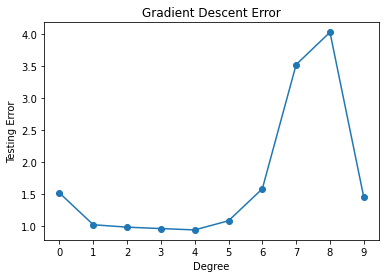

In [14]:
X = generate_feature_matrix(X_test, 9)
X = normalize_test(X, mean_norm, std_norm)

W = [i.reshape([len(i), 1]) for i in W_gradient]
testing_error_gradient = testing_polynomial_regression(Y_test, X, W)

rounded_test_error = [float("{:.3f}".format(testing_error_gradient[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Gradient Descent Error")
plt.show()

(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)
(55, 109)


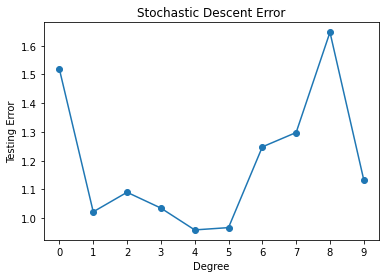

In [15]:
W = [i.reshape([len(i), 1]) for i in W_stochastic]
testing_error_stochastic = testing_polynomial_regression(Y_test, X, W)

rounded_test_error = [float("{:.3f}".format(testing_error_stochastic[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Stochastic Descent Error")
plt.show()

In [16]:
degrees = np.array([i for i in range(10)]).reshape([10,1])
polynomial_regression_result = np.concatenate((degrees, training_error_gradient, training_error_stochastic, testing_error_gradient, testing_error_stochastic), axis = 1)

In [17]:
polynomial_regression_table = pd.DataFrame(polynomial_regression_result, columns = ['Degree', 'Training Error (Gradient)', 'Training Error (Stochastic)','Testing Error (Gradient)', 'Testing Error (Stochastic)'])
polynomial_regression_table

,Degree,Training Error (Gradient),Training Error (Stochastic),Testing Error (Gradient),Testing Error (Stochastic)
0,0.0,1.3510,1.3510,1.518900,1.517987
1,1.0,0.8888,0.8889,1.022123,1.021981
2,2.0,0.8603,0.8800,0.984130,1.090455
3,3.0,0.8550,0.8699,0.961838,1.034797
4,4.0,0.8507,0.8637,0.941340,0.958855
5,5.0,0.8400,0.8626,1.083625,0.966533
6,6.0,0.8329,0.8634,1.582546,1.248348
7,7.0,0.8295,0.8608,3.523445,1.298239
8,8.0,0.8265,0.8582,4.027578,1.646545
9,9.0,0.8237,0.8566,1.451364,1.133332


# REGULARIZATION

In [18]:
def regularized_loss_function(Y, X, W, lam, q):

    loss1 = np.sum(1 / (2 * len(X[0])) * ((Y - W.T @ X) ** 2))
    loss2 = np.sum(lam / 2 * (np.abs(W) ** q))

    return loss1 + loss2

In [19]:
def error_function(Y, X, W):
    # print(f"Y: {Y.shape}, X: {X.shape}, W: {W.shape}")
    return np.sum(1 / (2 * len(X[0])) * ((Y - W.T @ X) ** 2))

In [20]:
# l = lambda
def regularized_gradient_descent(Y, X, W, q, alpha, l, iterations):
    N = X.shape[1]
    cost = np.zeros(iterations)
    # print(f"X: {X.shape}, N: {N}, Y: {Y.shape}, W: {W.shape}")
    for i in range(iterations):

        W = W - (alpha) * (((-1 / N) * (X @ (Y - W.T @ X).T)) + ((l / 2) * q * (np.abs(W) ** (q - 1))))
        cost[i] = regularized_loss_function(Y, X, W, l, q)

    return W, cost

In [21]:
X = np.concatenate((np.ones([1, len(X_train[0])]), X_train), axis = 0)
Y = Y_train

X_test = np.concatenate((np.ones([1, len(X_test[0])]), X_test), axis = 0)

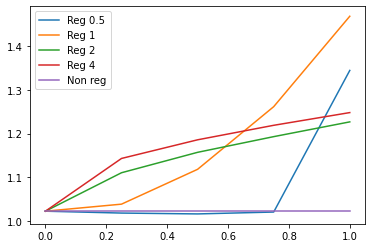

In [22]:
q_vec = [0.5, 1, 2, 4]
lam_vec = np.linspace(0, 1, 5)
alpha = 0.01
iterations = 100000

fig, ax = plt.subplots(1, 1)
for i in range(4):
    q = q_vec[i]
    cost_vec_reg = []
    for l in lam_vec:
        W = np.ones([3, 1])
        W, cost = regularized_gradient_descent(Y, X, W, q, alpha, l, iterations)
        cost_vec_reg.append(error_function(Y_test, X_test, W))
    ax.plot(lam_vec, cost_vec_reg, label=f"Reg {q}")

ax.plot(lam_vec, np.ones(len(lam_vec)) * testing_error_gradient[1][0], label=f"Non reg")

ax.legend()

plt.show()

In [23]:
def predict(x1, x2, degree):
    X = []
    for i in range(degree+1):
        for j in range(i+1):
            k = i - j
            X.append(x1 ** j * x2 ** k)
    X = np.array(X).reshape(-1, 1)
    d = X.shape[0]
    X = (X - mean_norm[:d]) / std_norm[:d]
    return W_gradient[degree] @ X

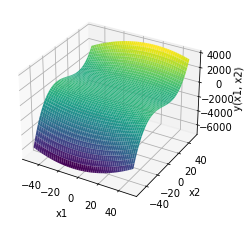

In [24]:
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

x1 = np.arange(-50, 50, 0.25)
x2 = np.arange(-50, 50, 0.25)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros(X1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x1 = X1[i][j]
        x2 = X2[i][j]
        Z[i][j] = predict(x1, x2, 3)


surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y(x1, x2)")
# fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()